In [115]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import sidetable as stb

from scipy import stats
import researchpy as rp
from scipy.stats import levene
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import warnings
warnings.filterwarnings('ignore')

In [116]:
df = pd.read_pickle('data/bikes_limpio.pkl')

In [117]:
# Comenzaremos eliminando las columnas de registrado y total, ya que en este modelo nuestra VR será casual.
df = df.drop(["registrado", "total"], axis = 1)

Comprobaremos si se cumplen las asunciones de nuestros datos:

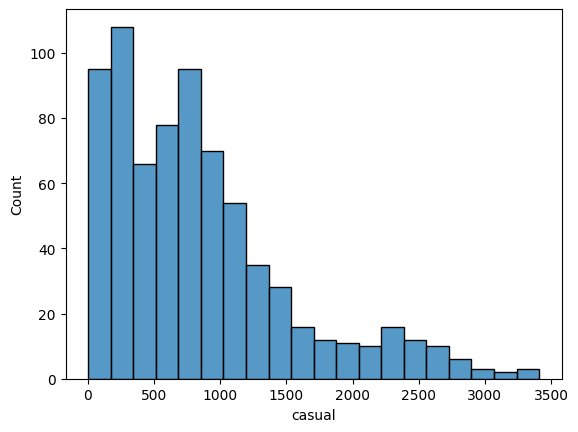

In [118]:
# Vamos a observar visualmente si nuestros datos son normales.
sns.histplot(x = df["casual"],  bins=20);

En principio parece que nuestros datos no son normales ya que no se asemejan a una campana de Gauss, pero lo comprobaremos de forma analítica.

In [119]:
# Comprobamos la normalidad con el test de shapiro ya que tenemos una muestra de datos pequeña:
stats.shapiro(df["casual"])

ShapiroResult(statistic=0.885096549987793, pvalue=7.659812252880885e-23)

El test nos confirma que nuestros datos NO son normales ya que nuestro p-value es menor a 0.05. Intentaremos normalizarlos.

In [120]:
# BOX-COX()
df["casual_box"], lambda_ajustada = stats.boxcox(df["casual"])

In [121]:
# Sacamos el p-value con el test de Saphiro para ver si se han normalizado. 
stats.shapiro(df["casual_box"])

ShapiroResult(statistic=0.9915904402732849, pvalue=0.00036475612432695925)

Después de intentar normalizar con varios métodos, el que mejor resultado nos ha dado es el BoxCox, no obstante tampoco consigue normalizar nuestros datos, por lo que la asunción de normalidad no se cumple y no podremos realizar el ANOVA ni el algoritmo de regresión lineal.

Pasamos a estandarizar nuestros datos.

In [122]:
# Eliminamos la columna respuesta y la columna "viento", ya que no hemos gestionado sus outliers.
df_estand = df.select_dtypes(include = np.number).drop(["casual", "casual_box", "viento"], axis = 1)

In [123]:
# Iniciamos el método.
scaler = StandardScaler()

In [124]:
# Ajustamos nuestros datos y lo convertimos a DataFrame.
X_escaladas = pd.DataFrame(scaler.fit_transform(df_estand), columns = df_estand.columns)

In [125]:
# Ponemos nuestros datos estandarizados en el DataFrame original
df[X_escaladas.columns] = X_escaladas

In [127]:
# Creamos un DataFrame con la columna de "viento".
df_robust = df["viento"].reset_index()

In [129]:
# Iniciamos el método robust, ya que no hemos gestionado outliers en "viento". 
robust = RobustScaler()

In [130]:
# Ajustamos nuestros datos y los convertimos a DataFrame
X_viento = pd.DataFrame(robust.fit_transform(df_robust), columns = df_robust.columns)

In [131]:
# Lo unimos al DataFrame original
df[X_viento.columns] = X_viento

In [133]:
df.drop(['index'], axis = 1, inplace = True)

In [134]:
# Creamos un DataFrame con las variables categóricas
df_categoricas = df.select_dtypes(include = "O")
df_categoricas.head()

,estacion,año,mes,festivo,dia_semana,laboral,clima
0,invierno,2018,enero,sí,lunes,no,niebla
1,invierno,2018,febrero,no,jueves,sí,niebla
2,invierno,2018,marzo,no,jueves,sí,cielo despejado
3,primavera,2018,abril,no,domingo,no,cielo despejado
4,primavera,2018,mayo,no,martes,sí,cielo despejado


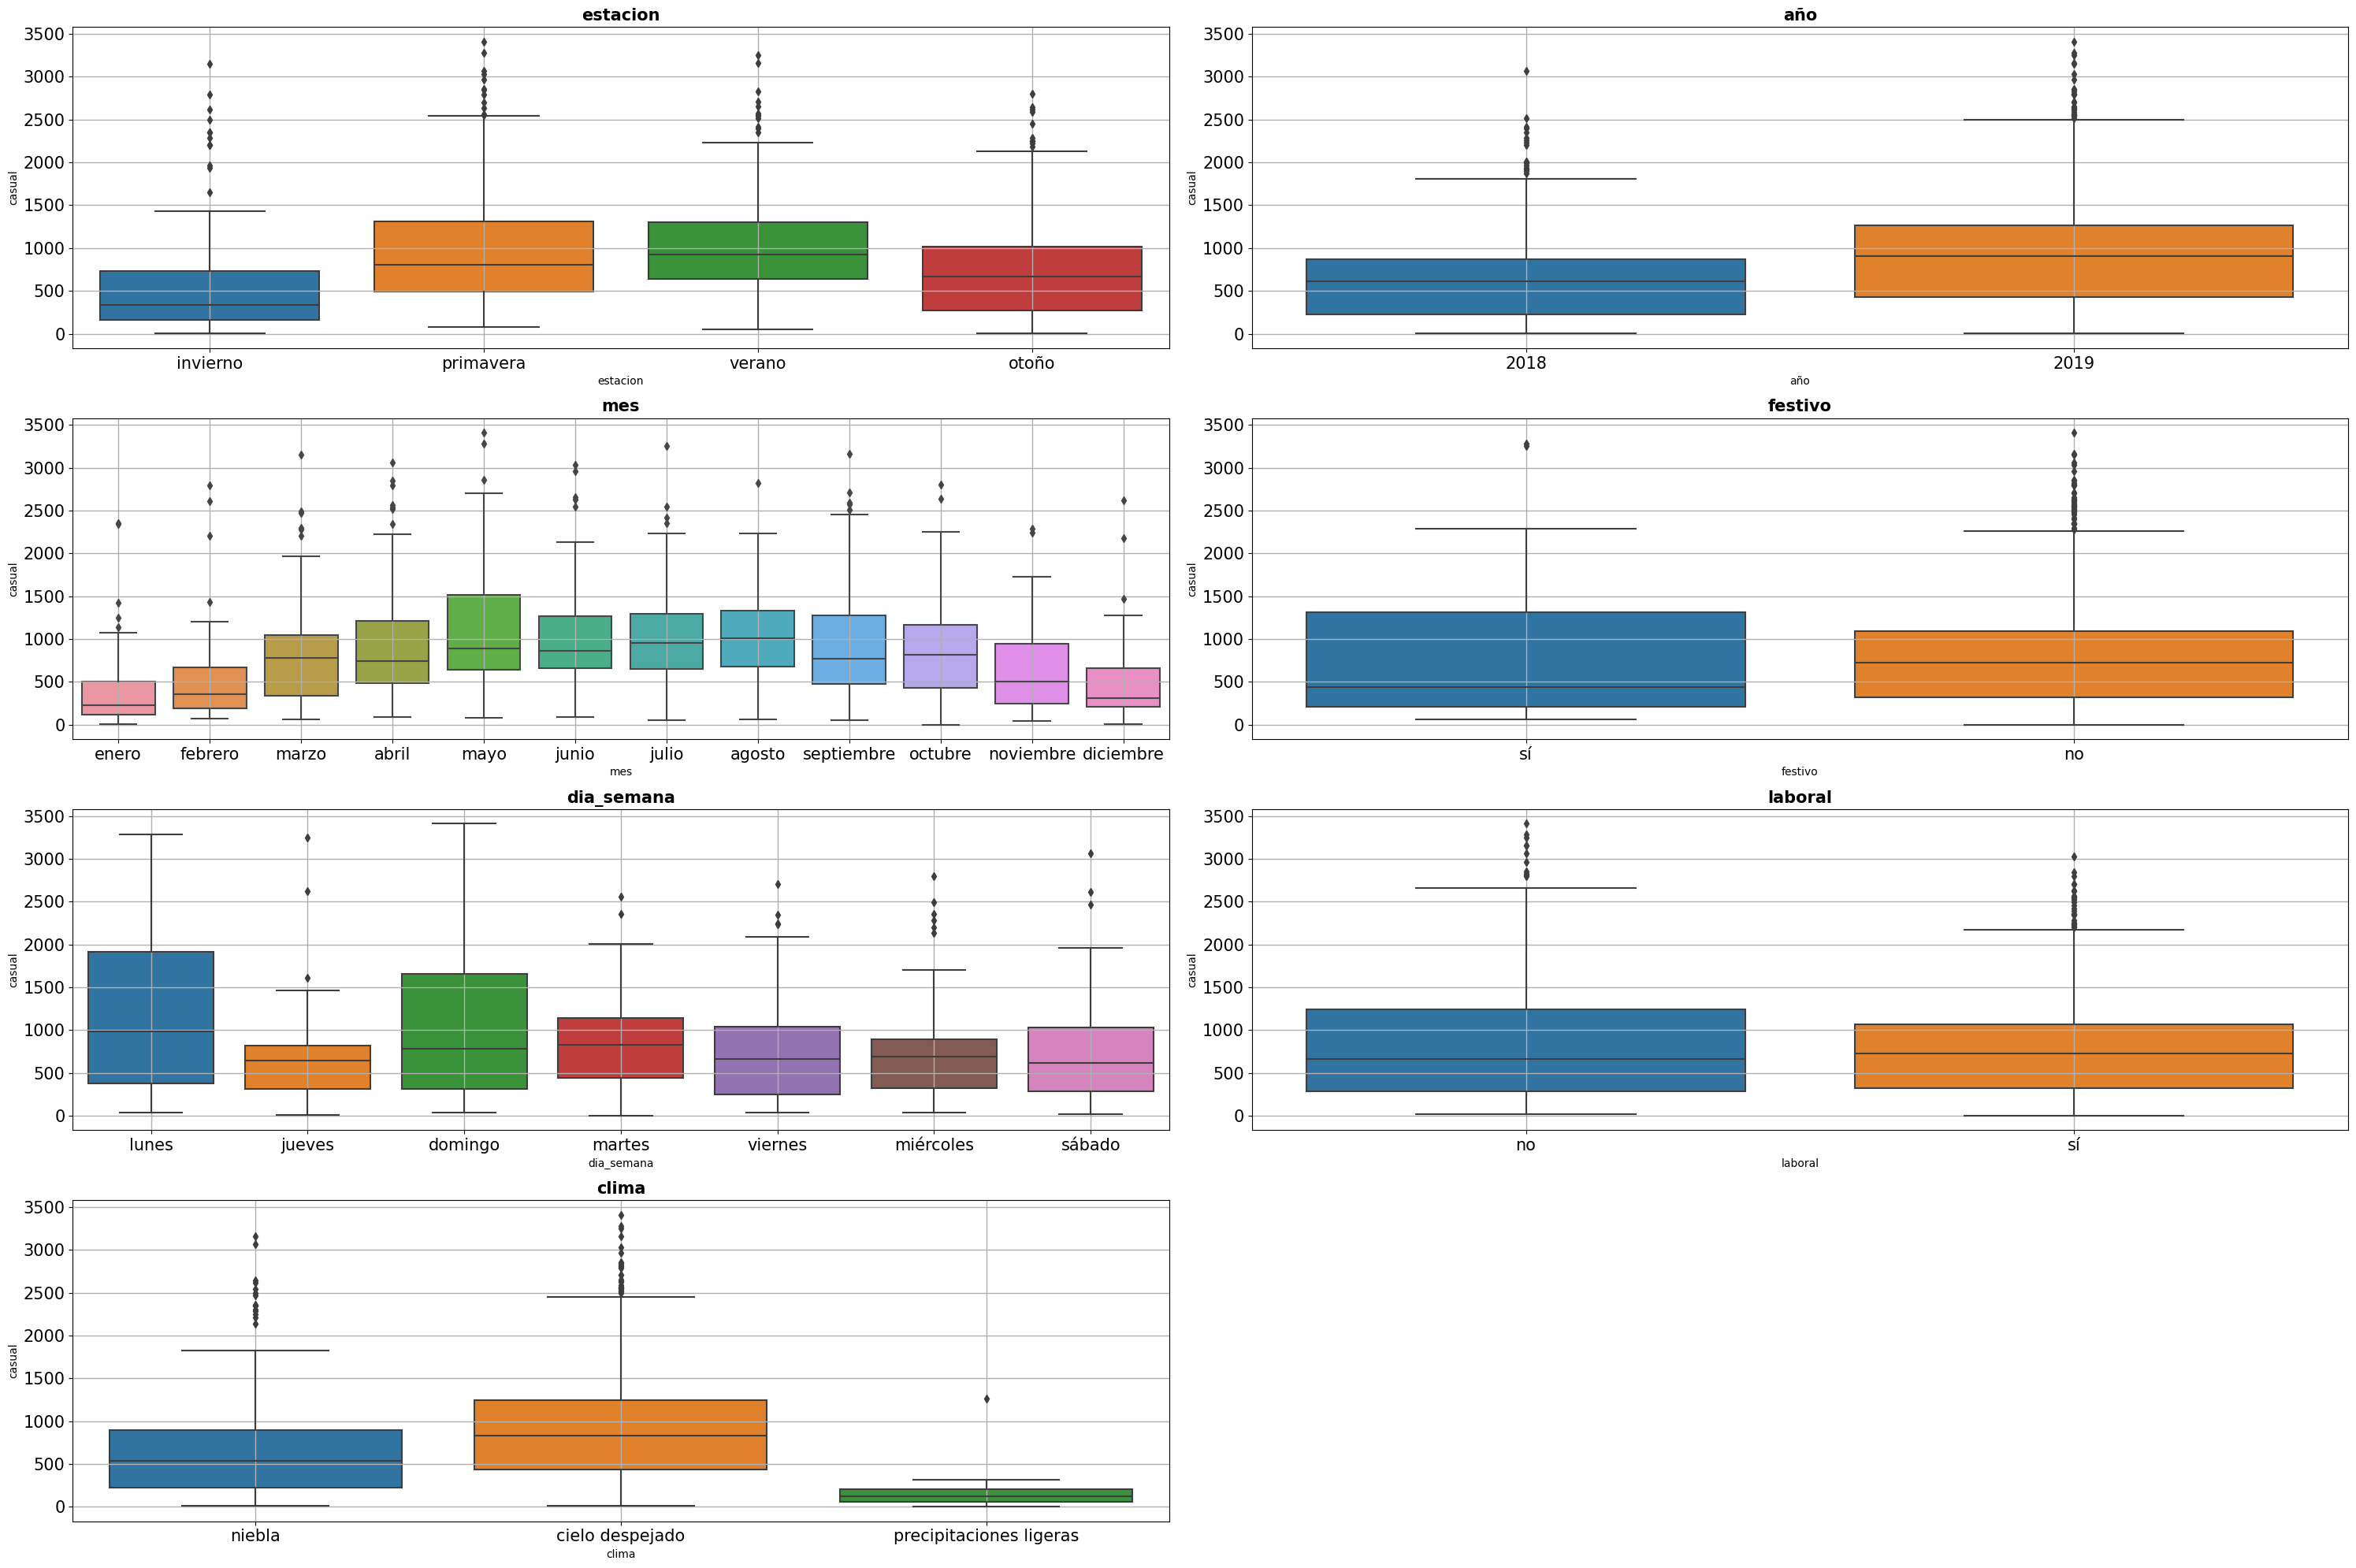

In [135]:
# Sacamos un boxplot para ver si tienen orden o no.
fig, axes = plt.subplots(4, 2, figsize = (30, 20))

axes = axes.flat

for i, columna in enumerate(df_categoricas): 
    sns.boxplot(
        data = df,
        x = columna,
        y = "casual",
        ax = axes[i])
    
    
    axes[i].set_title(columna, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 15)
    axes[i].grid(visible = True, linestyle = "-", linewidth = 1 )
fig.delaxes(axes[-1])
fig.tight_layout();

In [136]:
#Establecemos el orden. 

dict_estacion = {"invierno": 0, "otoño": 1, "primavera": 1.5, "verano": 2}
dict_mes = {"enero": 0, "febrero": 0, "diciembre": 0, "noviembre": 1, "marzo": 2, "abril": 2, "septiembre": 2, "octubre": 2, "mayo": 3, "junio": 3, "julio": 3, "agosto": 3}
dict_semana = {"jueves": 0, "viernes": 0, "sábado": 0, "miércoles": 0, "domingo": 0.5, "martes": 0.5, "lunes": 1}
dict_clima = {"precipitaciones ligeras": 0, "niebla": 1, "cielo despejado": 2}
dict_año = {"2018": 0, "2019": 1}
dict_festivo = {"sí": 0, "no": 1}

In [137]:
# Codificamos nuestras variables con el orden establecido.

dict_map = {"estacion": dict_estacion, "mes": dict_mes, "dia_semana": dict_semana, "clima": dict_clima, "año": dict_año, "festivo": dict_festivo}
for columna, orden in dict_map.items():
    df[columna] = df[columna].map(orden)

In [139]:
# Utilizamos el OneHotEncoder para codificar la variable "laboral", que no tiene orden. 
oh = OneHotEncoder()
transformados = oh.fit_transform(df[["laboral"]])
oh_df = pd.DataFrame(transformados.toarray())
oh_df.columns = oh.get_feature_names_out()
df = pd.concat([df,oh_df],axis=1)

In [140]:
df = df.drop("laboral", axis = 1)
df.head()

,fecha,estacion,año,mes,festivo,dia_semana,clima,temperatura,humedad,viento,casual,casual_box,laboral_no,laboral_sí
0,2018-01-01,0.0,0,0,0,1.0,1,-0.829070,1.268831,-0.212121,331,16.397820,1.0,0.0
1,2018-02-01,0.0,0,0,1,0.0,1,-0.722425,0.479838,0.696970,131,11.472437,0.0,1.0
2,2018-03-01,0.0,0,2,1,0.0,2,-1.628904,-1.377880,0.681818,120,11.076035,0.0,1.0
3,2018-04-01,1.5,0,2,1,0.5,2,-1.615573,-0.280463,-0.212121,108,10.613970,1.0,0.0
4,2018-05-01,1.5,0,3,1,0.5,2,-1.468937,-1.377880,0.060606,82,9.475537,0.0,1.0


In [141]:
df.to_pickle("data/procesados_casual.pkl")
df.to_csv("data/procesados_casual.csv")